This is a notebook that calculates neutron capture cross sections at a given T9 in units of millibarns $(mb)$

Here we import the relavent python packages

In [1]:
import sys
!{sys.executable} -m pip install --quiet wnutils

!{sys.executable} -m pip install --quiet gslconsts

import os, io, requests

import wnutils.xml as wx
import numpy as np
from gslconsts.consts import *
from matplotlib import pyplot as plt

Retrieve network data from [OSF](https://osf.io/5cyg7/) or use a local file.  To use a local file, upload the network XML file to the local directory and execute the relevant command.  In the commented case, the file would be *example.xml*, so you would upload that file and uncomment the read line.

In [2]:
my_xml = wx.Xml(io.BytesIO(requests.get('https://osf.io/kyhbs/download').content))
#my_xml = wx.Xml('example.xml')

Use an xpath expression to select out only $(n, \gamma)$ reaction data.

In [3]:
reac = my_xml.get_reaction_data("[reactant = 'n' and count(reactant) = 2  and product = 'gamma' and count(product) = 2]")

Now choose the temperature, T9, to calculate the cross sections.  Convert T9 to T in K.

Now calculate the thermal velocity.

In [4]:
T9 = 0.8
T = T9 * 1.e9

In [5]:
def v_thermal(T):
    return np.sqrt((2 * GSL_CONST_CGSM_BOLTZMANN * T) / GSL_CONST_CGSM_MASS_NEUTRON)

Create a dictionary of (n,g) reaction cross sections.

In [6]:
sig_dict = {}

for s in reac:
    reaction = reac[s]
    rate = reaction.compute_rate(T9)
    sigma = rate / (GSL_CONST_NUM_AVOGADRO * v_thermal(T9 * 1.e9))  # cross section in cm^2
        
    usigma = 1000 * sigma / GSL_CONST_CGSM_BARN
    sig_dict[s] = usigma 

Select a set of nuclides with an XPath expression.

In [7]:
nuc_xpath = "[z = 40 and a >= 90 and a <= 100]"

nuclides = my_xml.get_nuclide_data(nuc_xpath)

Retrieve the nuclides of interest.

In [8]:
my_filter = {}

for reaction in reac:
    for reactant in reac[reaction].reactants:
        if reactant in nuclides:
            my_filter[reaction] = [nuclides[reactant]['n']]
            
for reaction in reac:
    for reactant in reac[reaction].reactants:
        if reactant in nuclides:
            my_filter[reaction].append(reactant)
            

Create a new dictionary of the cross sections of interest.

In [9]:
rsig_dict = {k: sig_dict[k] for k in my_filter}

Change 2 in {.2f} to change the number of decimal places shown.

In [10]:
print('Cross Sections at T9 = ' + str(T9))
print()

for k in sorted(my_filter.keys(), key=lambda x: my_filter[x][0]):
    sig ="{:.2f}".format(rsig_dict[k])
    print(str(k)+': ' + str(sig) + ' mb')

Cross Sections at T9 = 0.8

n + zr90 -> zr91 + gamma: 14.40 mb
n + zr91 -> zr92 + gamma: 35.25 mb
n + zr92 -> zr93 + gamma: 21.69 mb
n + zr93 -> zr94 + gamma: 49.04 mb
n + zr94 -> zr95 + gamma: 21.76 mb
n + zr95 -> zr96 + gamma: 43.43 mb
n + zr96 -> zr97 + gamma: 5.29 mb
n + zr97 -> zr98 + gamma: 8.93 mb
n + zr98 -> zr99 + gamma: 7.32 mb
n + zr99 -> zr100 + gamma: 18.92 mb
n + zr100 -> zr101 + gamma: 5.68 mb


We now plot $\sigma_n$ vs $N$, the neutron number of the nuclides.

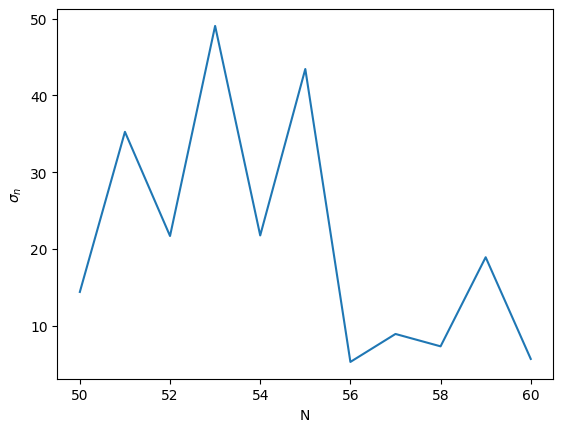

In [11]:
x = []
y = []

for k in sorted(my_filter.keys(), key=lambda x: my_filter[x][0]):
    x.append(my_filter[k][0])
    y.append(rsig_dict[k])

plt.plot(x, y)
plt.ylabel('$\\sigma_n$')
plt.xlabel('N')
plt.show()